In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands
from datetime import datetime as dt
import joblib

## Import CSVs

In [2]:
rf_pred = pd.read_csv('prediction csv/rf_random.csv', index_col=0)
arima_pred = pd.read_csv('prediction csv/arima.csv', index_col=0)
lstm_pred = pd.read_csv('prediction csv/lstm_pred.csv', index_col=0)

## Format rf_pred

In [3]:
rf_pred.index = pd.to_datetime(rf_pred.index)

In [4]:
rf_pred.drop(columns='Residual', inplace=True)
rf_pred

,Actual,RF_pred
Date,,
2021-01-04,128.189713,133.982366
2021-01-05,128.010849,130.505458
2021-01-06,130.088043,133.982366
2021-01-07,128.120163,129.519951
2021-01-08,126.361008,130.012704
...,...,...
2021-12-17,180.330002,133.170698
2021-12-20,179.289993,130.012704
2021-12-21,179.380005,130.992063


## Format arima_pred

In [ ]:
arima_pred.index = pd.to_datetime(arima_pred.index, yearfirst=True, dayfirst=True)

In [ ]:
arima_pred.drop(columns='y_actual', inplace=True)

In [ ]:
arima_pred.rename(columns={'arima_predicted':'arima_pred'}, inplace=True)

In [ ]:
arima_pred

## Format lstm_pred

In [5]:
lstm_pred.index = pd.to_datetime(lstm_pred.index)

In [6]:
lstm_pred.drop(columns='actual', inplace=True)

In [7]:
lstm_pred

,y_pred_LSTM
Date,
2021-01-04,37.250350
2021-01-05,37.244180
2021-01-06,36.586370
2021-01-07,37.019730
2021-01-08,37.626160
...,...
2021-12-17,120.968720
2021-12-20,119.670440
2021-12-21,117.874374


In [8]:
lstm_pred.rename(columns={'y_pred_LSTM':'LSTM_pred'}, inplace=True)
lstm_pred

,LSTM_pred
Date,
2021-01-04,37.250350
2021-01-05,37.244180
2021-01-06,36.586370
2021-01-07,37.019730
2021-01-08,37.626160
...,...
2021-12-17,120.968720
2021-12-20,119.670440
2021-12-21,117.874374


## Combine all dfs

In [9]:
comb_df = rf_pred.merge(lstm_pred, left_on='Date', right_on='Date')
comb_df

,Actual,RF_pred,LSTM_pred
Date,,,
2021-01-04,128.189713,133.982366,37.250350
2021-01-05,128.010849,130.505458,37.244180
2021-01-06,130.088043,133.982366,36.586370
2021-01-07,128.120163,129.519951,37.019730
2021-01-08,126.361008,130.012704,37.626160
...,...,...,...
2021-12-17,180.330002,133.170698,120.968720
2021-12-20,179.289993,130.012704,119.670440
2021-12-21,179.380005,130.992063,117.874374


## Scale features

In [10]:
#Instantiate scaler
scaler = StandardScaler()
#fit and transform features
comb_df[['RF_pred','LSTM_pred']] = scaler.fit_transform(comb_df[['RF_pred','LSTM_pred']])
#Show scaled features
comb_df

,Actual,RF_pred,LSTM_pred
Date,,,
2021-01-04,128.189713,2.347368,-1.089139
2021-01-05,128.010849,0.259478,-1.089378
2021-01-06,130.088043,2.347368,-1.114853
2021-01-07,128.120163,-0.332320,-1.098070
2021-01-08,126.361008,-0.036421,-1.074585
...,...,...,...
2021-12-17,180.330002,1.859960,2.152955
2021-12-20,179.289993,-0.036421,2.102677
2021-12-21,179.380005,0.551686,2.033123


## Splitting the Data 

In [11]:
train_length = len(comb_df)*0.8
test_length = len(comb_df)*0.2

In [12]:
X_train = comb_df[['RF_pred','LSTM_pred']][0:int(train_length)]
y_train = comb_df['Actual'][0:int(train_length)]
X_test = comb_df[['RF_pred','LSTM_pred']][int(train_length):]
y_test = comb_df['Actual'][int(train_length):]

## Fit linear model

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:
model.score(X_test, y_test)

0.3764664502562559

In [15]:
y_pred = model.predict(X_test)

In [20]:
metrics.mean_absolute_error(y_test, y_pred)

7.598365010973891

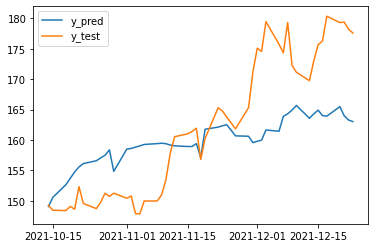

In [19]:
plt.plot(y_test.index, y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend()

## Without arima

In [ ]:
no_arima_df = comb_df.drop(columns='arima_pred')
no_arima_df

In [ ]:
X_train_na = no_arima_df[['RF_pred', 'LSTM_pred']][0:int(train_length)]
X_test_na = no_arima_df[['RF_pred', 'LSTM_pred']][int(train_length):]

In [ ]:
X_train_na

In [ ]:
model = LinearRegression()
model.fit(X_train_na, y_train)

In [ ]:
model.score(X_test_na, y_test)

In [ ]:
new_y_pred = model.predict(X_test_na)

In [ ]:
metrics.mean_absolute_error(y_test, new_y_pred)

## Plot graph

In [ ]:
plt.plot(y_test.index, new_y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend();

## Ridge Regression

In [ ]:
from sklearn import linear_model

In [ ]:
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train_na, y_train)

In [ ]:
reg.score(X_test_na, y_test)

In [ ]:
reg_y_pred = reg.predict(X_test_na)

In [ ]:
metrics.mean_absolute_error(y_test, reg_y_pred)

In [ ]:
plt.plot(y_test.index, reg_y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend();